In [32]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import ttest_rel, wilcoxon



In [16]:
# ---------- Distance ----------
def euclidean_distance(a, b):
    return float(np.sqrt(np.sum((a - b) ** 2)))



In [17]:
# ---------- My KNN ----------
def knn_predict_single(train_X, train_y, sample, k=3, weighted=False):
    distances = np.linalg.norm(train_X - sample, axis=1)
    idx = np.argsort(distances)[:k]
    neighbor_labels = train_y[idx]
    if not weighted:
        counts = Counter(neighbor_labels)
        most_common = counts.most_common()
        most_common.sort(key=lambda x: (-x[1], x[0]))
        return most_common[0][0]
    else:
        eps = 1e-8
        weights = 1.0 / (distances[idx] + eps)
        wsum = defaultdict(float)
        for lbl, w in zip(neighbor_labels, weights):
            wsum[lbl] += w
        return max(wsum.items(), key=lambda x: (x[1], -float(x[0])))[0]

def knn_predict_batch(train_X, train_y, test_X, k=3, weighted=False):
    preds = []
    for i in range(test_X.shape[0]):
        preds.append(knn_predict_single(train_X, train_y, test_X[i], k, weighted))
    return np.array(preds)



In [33]:
# ---------- K-Fold CV ----------
def evaluate_knn_kfold(X, y, k_nn=3, folds=10, weighted=False, seed=0):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    accs = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        preds = knn_predict_batch(X_train, y_train, X_test, k=k_nn, weighted=weighted)
        accs.append(accuracy_score(y_test, preds))
    return accs

def evaluate_sklearn_knn_kfold(X, y, k_nn=3, folds=10, seed=0):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    accs = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf = KNeighborsClassifier(n_neighbors=k_nn)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        accs.append(accuracy_score(y_test, preds))
    return accs



In [19]:
# ---------- Hypothesis Test ----------
def paired_tests(accs_a, accs_b):
    accs_a, accs_b = np.array(accs_a), np.array(accs_b)
    t_stat, p_val_t = ttest_rel(accs_a, accs_b)
    return {
        "t_stat": t_stat,
        "p_val_t": p_val_t,
        "mean_diff": accs_a.mean() - accs_b.mean()
    }


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Store results
results = []
all_fold_results = {}   # to keep per-fold accuracies for boxplots

# ---------------- Hayes-Roth ----------------
df = pd.read_csv("/Users/harmanpreetkaur/Downloads/hayes-roth.data", header=None)
df.columns = ["id", "hobby", "age", "education", "marital", "class"]
print(df.head())
print("Shape:", df.shape)

df = df.drop(columns=["id"])



    id  hobby  age  education  marital  class
0   92      2    1          1        2      1
1   10      2    1          3        2      2
2   83      3    1          4        1      3
3   61      2    4          2        2      3
4  107      1    1          3        4      3
Shape: (132, 6)


In [35]:
# Encode categorical
for col in ["hobby", "age", "education", "marital"]:
    df[col] = df[col].astype(int)

le = LabelEncoder()
df["class"] = le.fit_transform(df["class"].astype(int))
print(df.head())

X = df.drop(columns=["class"]).values
y = df["class"].values
X = StandardScaler().fit_transform(X)



   hobby  age  education  marital  class
0      2    1          1        2      0
1      2    1          3        2      1
2      3    1          4        1      2
3      2    4          2        2      2
4      1    1          3        4      2


In [36]:
my_accs = evaluate_knn_kfold(X, y, k_nn=3, folds=10)
sk_accs = evaluate_sklearn_knn_kfold(X, y, k_nn=3, folds=10)
tests = paired_tests(my_accs, sk_accs)
print("My KNN accuracies per fold:", my_accs)
print("My KNN mean accuracy:", np.mean(my_accs))
print("Sklearn KNN mean accuracy:", np.mean(sk_accs))
print("Hypothesis Test:", tests)
results.append(("Hayes-Roth", np.mean(my_accs), np.mean(sk_accs), tests["p_val_t"]))
all_fold_results["Hayes-Roth"] = (my_accs, sk_accs)



My KNN accuracies per fold: [0.5, 0.6428571428571429, 0.6153846153846154, 0.5384615384615384, 0.6923076923076923, 0.5384615384615384, 0.5384615384615384, 0.8461538461538461, 0.46153846153846156, 0.3076923076923077]
My KNN mean accuracy: 0.5681318681318681
Sklearn KNN mean accuracy: 0.5983516483516483
Hypothesis Test: {'t_stat': np.float64(-2.447467877194916), 'p_val_t': np.float64(0.036909713421578984), 'mean_diff': np.float64(-0.030219780219780223)}


In [37]:
# ---------------- Car Evaluation ----------------
df = pd.read_csv("/Users/harmanpreetkaur/Downloads/car+evaluation/car.data", header=None)
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
print(df.head())
print("Shape:", df.shape)





  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc
Shape: (1728, 7)


In [38]:
for col in ["buying", "maint", "doors", "persons", "lug_boot", "safety"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

le = LabelEncoder()
df["class"] = le.fit_transform(df["class"].astype(str))

X = df.drop(columns=["class"]).values
y = df["class"].values
X = StandardScaler().fit_transform(X)




In [39]:
my_accs = evaluate_knn_kfold(X, y, k_nn=3, folds=10)
sk_accs = evaluate_sklearn_knn_kfold(X, y, k_nn=3, folds=10)
tests = paired_tests(my_accs, sk_accs)
print("My KNN accuracies per fold:", my_accs)
print("My KNN mean accuracy:", np.mean(my_accs))
print("Sklearn KNN mean accuracy:", np.mean(sk_accs))
print("Hypothesis Test:", tests)
results.append(("Car Evaluation", np.mean(my_accs), np.mean(sk_accs), tests["p_val_t"]))
all_fold_results["Car Evaluation"] = (my_accs, sk_accs)


My KNN accuracies per fold: [0.8728323699421965, 0.9190751445086706, 0.930635838150289, 0.9364161849710982, 0.9132947976878613, 0.9075144508670521, 0.930635838150289, 0.9595375722543352, 0.9418604651162791, 0.9186046511627907]
My KNN mean accuracy: 0.9230407312810863
Sklearn KNN mean accuracy: 0.9265291033741094
Hypothesis Test: {'t_stat': np.float64(-1.0355168165348518), 'p_val_t': np.float64(0.327448701459279), 'mean_diff': np.float64(-0.0034883720930231066)}


In [40]:
# ---------------- Breast Cancer ----------------
df = pd.read_csv("/Users/harmanpreetkaur/Downloads/breast+cancer/breast-cancer.data", header=None)
print(df.head())
print("Shape:", df.shape)
df.columns = [
    "class", "age", "menopause", "tumor_size", "inv_nodes", "node_caps",
    "deg_malig", "breast", "breast_quad", "irradiat"
]

df = df.replace("?", np.nan)
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])




                      0      1        2      3    4   5  6      7          8  \
0  no-recurrence-events  30-39  premeno  30-34  0-2  no  3   left   left_low   
1  no-recurrence-events  40-49  premeno  20-24  0-2  no  2  right   right_up   
2  no-recurrence-events  40-49  premeno  20-24  0-2  no  2   left   left_low   
3  no-recurrence-events  60-69     ge40  15-19  0-2  no  2  right    left_up   
4  no-recurrence-events  40-49  premeno    0-4  0-2  no  2  right  right_low   

    9  
0  no  
1  no  
2  no  
3  no  
4  no  
Shape: (286, 10)


In [41]:
for col in df.columns:
    if col != "class":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

le = LabelEncoder()
df["class"] = le.fit_transform(df["class"].astype(str))

X = df.drop(columns=["class"]).values
y = df["class"].values
X = StandardScaler().fit_transform(X)

my_accs = evaluate_knn_kfold(X, y, k_nn=3, folds=10)
sk_accs = evaluate_sklearn_knn_kfold(X, y, k_nn=3, folds=10)
tests = paired_tests(my_accs, sk_accs)
print("My KNN accuracies per fold:", my_accs)
print("My KNN mean accuracy:", np.mean(my_accs))
print("Sklearn KNN mean accuracy:", np.mean(sk_accs))
print("Hypothesis Test:", tests)
results.append(("Breast Cancer", np.mean(my_accs), np.mean(sk_accs), tests["p_val_t"]))
all_fold_results["Breast Cancer"] = (my_accs, sk_accs)



My KNN accuracies per fold: [0.7241379310344828, 0.7241379310344828, 0.4827586206896552, 0.7586206896551724, 0.7586206896551724, 0.7241379310344828, 0.7142857142857143, 0.8928571428571429, 0.6071428571428571, 0.6428571428571429]
My KNN mean accuracy: 0.7029556650246306
Sklearn KNN mean accuracy: 0.6993842364532019
Hypothesis Test: {'t_stat': np.float64(1.0), 'p_val_t': np.float64(0.34343639613791355), 'mean_diff': np.float64(0.0035714285714286698)}


          Dataset  My KNN Mean Acc  Sklearn KNN Mean Acc  p-value (t-test)
0      Hayes-Roth         0.568132              0.598352          0.036910
1  Car Evaluation         0.923041              0.926529          0.327449
2   Breast Cancer         0.702956              0.699384          0.343436


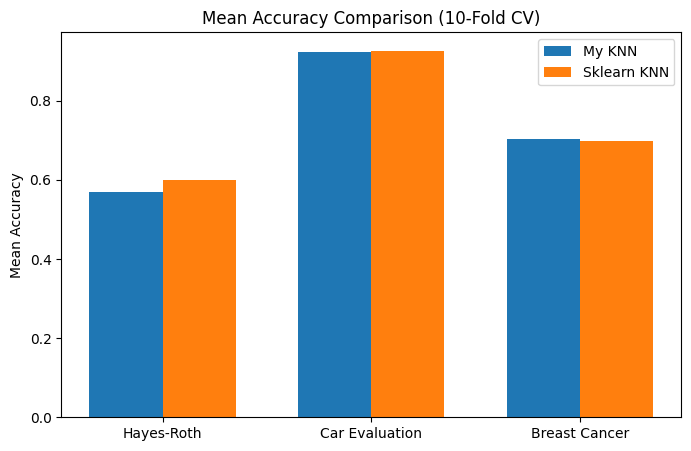

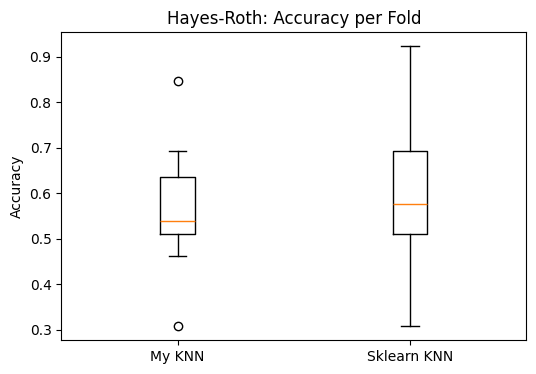

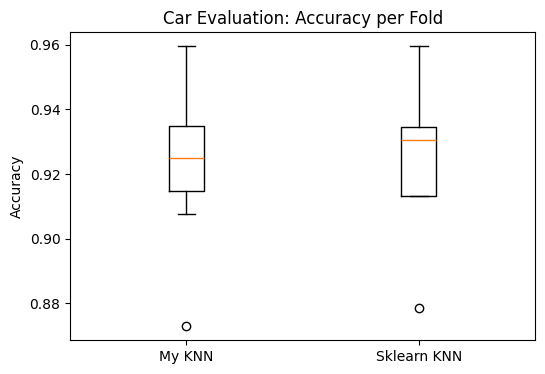

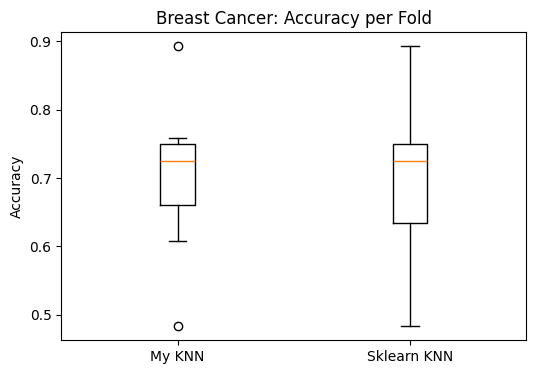

In [42]:
# ---------------- Summary Table ----------------
summary = pd.DataFrame(results, columns=["Dataset", "My KNN Mean Acc", "Sklearn KNN Mean Acc", "p-value (t-test)"])
print(summary)

# ---------------- Bar Chart ----------------
datasets = [r[0] for r in results]
my_means = [r[1] for r in results]
sk_means = [r[2] for r in results]

x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, my_means, width, label="My KNN")
plt.bar(x + width/2, sk_means, width, label="Sklearn KNN")
plt.xticks(x, datasets)
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy Comparison (10-Fold CV)")
plt.legend()
plt.savefig("comparison_bar_chart.png", dpi=300)
plt.show()

# ---------------- Boxplots for Each Dataset ----------------
for dataset, (my_accs, sk_accs) in all_fold_results.items():
    plt.figure(figsize=(6,4))
    plt.boxplot([my_accs, sk_accs], tick_labels=["My KNN", "Sklearn KNN"])
    plt.title(f"{dataset}: Accuracy per Fold")
    plt.ylabel("Accuracy")
    plt.savefig(f"{dataset.lower().replace(' ','_')}_boxplot.png", dpi=300)
    plt.show()


In [2]:
import sys
print(sys.executable)


/Users/harmanpreetkaur/.pyenv/versions/3.13.5/bin/python
